# Segmentation

## Mean Shift Segmentation

### I have both used library and non-library

#### using library (run quick)

In [1]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from collections import defaultdict
import cv2
import math

In [2]:
image = cv2.imread('stop.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.array(image)

(-0.5, 483.5, 639.5, -0.5)

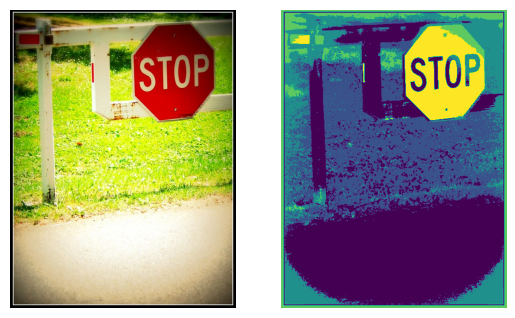

In [3]:
original_shape = image.shape
# Flatten image.
X = np.reshape(image, [-1, 3])
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=700)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
segmented_image = np.reshape(labels, original_shape[:2])  # Just take size, ignore RGB channels.
plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.axis('off')

#### without using library (run too slow, but works)

In [4]:
class MyMeanShift:
    def __init__(self, epsilon=1e-5, band_width=2, min_fre=3, bin_seeding=False):
        self.epsilon = epsilon
        self.band_width = band_width
        self.min_fre = min_fre  # The minimum number of samples inside the starting centroid's sphere
        self.bin_seeding = bin_seeding
        self.radius2 = self.band_width ** 2  # Square of the radius of the high-dimensional sphere

        self.N = None
        self.labels = None
        self.centers = []
        self.center_score = []

    def init_param(self, data):
        # Initialize parameters
        self.N = data.shape[0]
        self.labels = -1 * np.ones(self.N)
        return

    def get_seeds(self, data):
        # Get points that can serve as starting centroids (seeds)
        if self.bin_seeding:
            binsize = self.band_width
        else:
            binsize = 1
        seed_list = []
        seeds_fre = defaultdict(int)
        for sample in data:
            seed = tuple(np.round(sample / binsize))  # Quantize the data to avoid very close sample points as seeds
            seeds_fre[seed] += 1
        for seed, fre in seeds_fre.items():
            if fre >= self.min_fre:
                seed_list.append(np.array(seed))
        if not seed_list:
            raise ValueError('The bin size and min_fre are not proper')
        return seed_list

    def euclidean_dis2(self, center, sample):
        # Calculate the squared Euclidean distance from the mean point to each sample
        delta = center - sample
        return delta @ delta

    def gaussian_kel(self, dis2):
        # Calculate the Gaussian kernel
        return 1.0 / self.band_width * (2 * math.pi) ** (-1.0 / 2) * math.exp(-dis2 / (2 * self.band_width ** 2))

    def shift_center(self, current_center, data, tmp_center_score):
        # Calculate the next shift of the center
        denominator = 0  # Denominator
        numerator = np.zeros_like(current_center)  # Numerator, in the form of a 1D array
        for ind, sample in enumerate(data):
            dis2 = self.euclidean_dis2(current_center, sample)
            if dis2 <= self.radius2:
                tmp_center_score += 1
            d = self.gaussian_kel(dis2)
            denominator += d
            numerator += d * sample
        return numerator / denominator

    def classify(self, data):
        # Classify data to the nearest cluster based on the nearest centroid
        center_arr = np.array(self.centers)
        for i in range(self.N):
            delta = center_arr - data[i]
            dis2 = np.sum(delta * delta, axis=1)
            self.labels[i] = np.argmin(dis2)
        return

    def fit(self, data):
        # Main training function
        self.init_param(data)
        seed_list = self.get_seeds(data)
        for seed in seed_list:
            current_center = seed
            tmp_center_score = 0
            # Perform one independent mean shift
            while True:
                next_center = self.shift_center(current_center, data, tmp_center_score)
                delta_dis = np.linalg.norm(next_center - current_center, 2)
                if delta_dis < self.epsilon:
                    break
                current_center = next_center
            # If the final center after shifting is within the bandwidth from an existing center, merge them
            for i in range(len(self.centers)):
                if np.linalg.norm(current_center - self.centers[i], 2) < self.band_width:
                    if tmp_center_score > self.center_score[i]:
                        self.centers[i] = current_center
                        self.center_score[i] = tmp_center_score
                    break
            else:
                self.centers.append(current_center)
                self.center_score.append(tmp_center_score)
        self.classify(data)
        return


In [5]:
def euclidean_distance(a, b):
    # calculate the euclidean distance between two vectors
    return np.sqrt(np.sum((a - b) ** 2))

def estimate_bandwidth_manual(X, quantile=0.1, n_samples=700, k_neighbors=10):
    # Select a subset of the data
    if len(X) > n_samples:
        np.random.seed(42)  # Ensure reproducibility of results
        X = X[np.random.choice(X.shape[0], n_samples, replace=False)]
    
    n = X.shape[0]
    nearest_distances = []

    # Calculate the k nearest neighbor distances for each point
    for i in range(n):
        distances = []
        for j in range(n):
            if i != j:
                dist = euclidean_distance(X[i], X[j])
                distances.append(dist)
        # Sort the distances and take the k smallest
        distances.sort()
        nearest_distances.append(distances[:k_neighbors])
    
    # Flatten and sort all nearest neighbor distances
    nearest_distances = np.array(nearest_distances).flatten()
    nearest_distances.sort()
    
    # Select the distance corresponding to the specified quantile as the bandwidth
    bandwidth = nearest_distances[int(quantile * len(nearest_distances))]
    
    return bandwidth


In [6]:
X = np.reshape(image, [-1, 3])
bandwidthK = estimate_bandwidth_manual(X, quantile=0.1, n_samples=700)
ms = MyMeanShift(bandwidthK, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
segmented_image = np.reshape(labels, original_shape[:2])  # Just take size, ignore RGB channels.
plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.axis('off')

KeyboardInterrupt: 

## Normalized Graph Cut Segmentation

In [7]:
from scipy.sparse import csr_matrix

def create_graph(image, sigma=1.0):
    # 获取图像的大小
    rows, cols = image.shape
    
    # 创建图的邻接矩阵
    num_nodes = rows * cols
    row_indices = []
    col_indices = []
    values = []
    
    # 遍历每个像素
    for r in range(rows):
        for c in range(cols):
            node = r * cols + c
            
            # 获取相邻像素
            neighbors = [(r - 1, c), (r + 1, c), (r, c - 1), (r, c + 1)]  # 上、下、左、右邻居
            
            for nr, nc in neighbors:
                if 0 <= nr < rows and 0 <= nc < cols:
                    neighbor_node = nr * cols + nc
                    # 计算相似度（使用高斯相似度）
                    diff = image[r, c] - image[nr, nc]
                    weight = np.exp(- (diff ** 2) / (2 * sigma ** 2))
                    row_indices.append(node)
                    col_indices.append(neighbor_node)
                    values.append(weight)
    
    # 创建稀疏矩阵
    graph_matrix = csr_matrix((values, (row_indices, col_indices)), shape=(num_nodes, num_nodes))
    return graph_matrix

# 创建图
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
graph = create_graph(gray_image)


/var/folders/9c/xln12s6n5x5bg43jtfns1vh00000gn/T/ipykernel_60345/1446215227.py:25: RuntimeWarning: overflow encountered in scalar subtract
  diff = image[r, c] - image[nr, nc]


In [ ]:
from scipy.linalg import eigh

def normalized_cut(graph):
    # 计算图的度矩阵和拉普拉斯矩阵
    degree_matrix = np.array(graph.sum(axis=1)).flatten()  # 每个节点的度
    degree_matrix_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))  # 度矩阵的逆平方根
    laplacian_matrix = degree_matrix_inv_sqrt @ graph.toarray() @ degree_matrix_inv_sqrt
    
    # 计算拉普拉斯矩阵的最小特征向量
    eigvals, eigvecs = eigh(laplacian_matrix)
    
    # 选择最小的特征向量
    return eigvecs[:, 1]  # 通常选择第二小的特征向量作为分割依据

# 计算图割
eigvec = normalized_cut(graph)

/var/folders/9c/xln12s6n5x5bg43jtfns1vh00000gn/T/ipykernel_60345/4292373558.py:6: RuntimeWarning: divide by zero encountered in divide
  degree_matrix_inv_sqrt = np.diag(1.0 / np.sqrt(degree_matrix))  # 度矩阵的逆平方根


In [ ]:
from sklearn.cluster import KMeans

def segment_image(eigvec, image_shape):
    # 将特征向量归一化
    eigvec = eigvec / np.linalg.norm(eigvec)
    
    # 使用k-means进行分割
    kmeans = KMeans(n_clusters=2)  # 两个簇，背景和前景
    labels = kmeans.fit_predict(eigvec.reshape(-1, 1))  # 扁平化特征向量
    segmented_image = labels.reshape(image_shape)
    return segmented_image

# 获取分割结果
segmented_image = segment_image(eigvec, gray_image.shape)

# 显示分割结果
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image')
plt.show()

In [ ]:
# 显示原图和分割结果
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(segmented_image, cmap='gray')
ax[1].set_title('Segmented Image')
plt.show()